# Model Evaluation

In this tutorial we go through the **Model Fitting and Evaluation**, to perform after the **Feature Selection** step. If **PCA** is selected as the Feature Selection method, it is performed right before the Model Fitting.


Initially, the feature set is splitted into train/test set. 
Then, the train set is used to perform a *5-fold CV*, including **Feature Selection** and **Model Fitting**.
The CV classification performance (*ROC-AUC* score in this tutorial) is then analyzed to select the best model. In this tutorial we refer to *model* as the combination of a *classifier* (i.e. Random Forest) and a *number of selected features* (i.e. 5 features).

Finally, the best model is used to perform feature selection and model fitting on the train set. The test set is used to evaluate the classification performance of the model.

In case of *model ensembling* k-top models are selected, and the CV classification scores (ROC-AUC) are using as weight factors for the single classifiers predictions.

The *classification performance* are reported as **YellowBrick** plots and in a summary table.


## Imports

In [50]:
import numpy as np
import pandas as pd
from pathlib import Path

import warnings
warnings.filterwarnings(action='once')

from Hive_ML.utilities.feature_utils import data_shuffling
import json 
from importlib.resources import as_file, files
import Hive_ML.configs
import os
import plotly.express as px
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [2]:
from Hive_ML.training.models import adab_tree, random_forest, knn, decicion_tree, lda, qda, naive, svm_kernel, logistic_regression, ridge, mlp
from Hive_ML.training.model_trainer import model_fit_and_predict
MODELS = {
    "rf": random_forest,
    "adab": adab_tree,
    "lda": lda,
    "qda": qda,
    "logistic_regression": logistic_regression,
    "knn": knn,
    "naive": naive,
    "decision_tree": decicion_tree,
    "svm": svm_kernel,
    "ridge": ridge,
    "mlp": mlp
}

In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from yellowbrick.classifier import ClassificationReport, ROCAUC, PrecisionRecallCurve, ClassPredictionError, DiscriminationThreshold
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load Configuration

In [4]:
config_file = "Radiodynamics_config.json"

try:
    with open(config_file) as json_file:
        config_dict = json.load(json_file)
except FileNotFoundError:
    with as_file(files(Hive_ML.configs).joinpath(config_file)) as json_path:
        with open(json_path) as json_file:
            config_dict = json.load(json_file)

## Features Loading and Aggregation

Radiomics Features are aggregagated across the 3D Sequences:

$F\mu_{p,i}=\frac{1}{N} \sum_{n=0}^N F_{n, p, i}$

$F\sigma_{p,i}= \sqrt{\frac{\sum_{n=0}^N (F_{n, p, i} - F\mu_{p,i})^2}{N}}$

$F\Delta_{p,i}=\frac{1}{N} \sum_{n=0}^N |F_{n, p, i}- F\mu_{p,i}|$

with $ p = patient_p, i = feature_i$

In [5]:
def get_feature_set_details(feature_set):

    n_sequences = feature_set[["Subject_ID", "Sequence_Number"]].groupby("Subject_ID").count()
    n_sequences = max(n_sequences["Sequence_Number"])
    subjects_and_labels = feature_set[["Subject_ID", "Subject_Label"]].drop_duplicates()

    subject_ids = subjects_and_labels["Subject_ID"].values
    subject_labels = subjects_and_labels["Subject_Label"].values

    feature_list = []
    for sequence in range(n_sequences):
        sequence_feature_list = []
        for subject in subject_ids:
            feature_set_subject = feature_set[
                (feature_set["Subject_ID"] == subject) & (feature_set["Sequence_Number"] == sequence)]
            feature_set_subject = feature_set_subject.copy(deep=True)
            feature_set_subject.drop("Subject_ID", inplace=True, axis=1)
            feature_set_subject.drop("Subject_Label", inplace=True, axis=1)
            feature_set_subject.drop("Sequence_Number", inplace=True, axis=1)
            if feature_set_subject.values.shape[0] > 0:
                sequence_feature_list.append(feature_set_subject.values)
            else:
                nan_array = numpy.empty((1, feature_set_subject.values.shape[1]))
                nan_array[:] = numpy.nan
                sequence_feature_list.append(nan_array)
        feature_list.append(sequence_feature_list)

    feature_set_names = feature_set.copy(deep=True)
    feature_set_names.drop("Subject_ID", inplace=True, axis=1)
    feature_set_names.drop("Subject_Label", inplace=True, axis=1)
    feature_set_names.drop("Sequence_Number", inplace=True, axis=1)
    feature_names = feature_set_names.columns
    return feature_list, subject_ids, subject_labels, feature_names


In [6]:
def get_4D_feature_stats(feature_list):

    feature_arrays = np.array(feature_list).squeeze(axis=-2)

    mean_features = np.nanmean(feature_arrays, axis=0)
    sum_features = np.nansum(feature_arrays, axis=0)
    std_features = np.nanstd(feature_arrays, axis=0)

    delta_features = np.absolute(np.subtract(feature_arrays, mean_features))
    mean_delta_features = np.nanmean(delta_features, axis=0)

    return mean_features, sum_features, std_features, mean_delta_features

In [7]:
data_folder = "Data/DCE_MRI_dataset"
feature_set_filename = str(Path(data_folder).joinpath("Perfusion_Radiomics.xlsx"))
feature_set = pd.read_excel(feature_set_filename, index_col=0)

feature_set = feature_set.sort_values(by=['Subject_Label','Subject_ID','Sequence_Number'])

feature_list, subject_ids, subject_labels, feature_names = get_feature_set_details(feature_set)
mean_features, sum_features, std_features, mean_delta_features = get_4D_feature_stats(feature_list)

# 3D Feature Array Flattening into 2D Array

$ F_{n,p,i} $ to $ F_{p,i*n} $

In [8]:
def flatten_4D_features(feature_list, feature_names):
    feature_arrays = np.array(feature_list).squeeze(axis=-2)
    flat_feature_array = np.zeros((feature_arrays.shape[1], 1))

    if feature_arrays.shape[0] > 1:
        T = feature_arrays.shape[0]
        n_features = feature_arrays.shape[2]
        for n in range(n_features):
            for t in range(T):
                flat_feature_array = np.hstack(
                    [flat_feature_array, feature_arrays[t, :, n].reshape(feature_arrays.shape[1], 1)])

        flatten_feature_names = []
        for feature_name in feature_names:
            for t in range(T):
                flatten_feature_names.append("{}_{}".format(t, feature_name))
        return flat_feature_array[:, 1:], flatten_feature_names

    else:
        return feature_list, feature_names

In [9]:
feature_list_flatten, feature_names_flatten = flatten_4D_features(feature_list, feature_names)

label_set = np.array(subject_labels)

In [10]:
print("# Features: {}".format(feature_list_flatten.shape[1:]))
print("#Labels: {}".format(label_set.shape))

# Features: (352,)
#Labels: (80,)


## Feature Filtering

Features where > 50% of values are identical are removed.

In [11]:
#features = mean_features
features = feature_list_flatten
feature_names = feature_names_flatten

n_features = features.shape[1]
n_subjects = features.shape[0]

filtered_feature_set = []
filtered_feature_names = []
features = np.nan_to_num(features)
for feature in range(n_features):
    exclude = False
    for feature_val in np.unique(features[:, feature]):
        if (np.count_nonzero(features[:, feature] == feature_val) / n_subjects) > 0.5:
            exclude = True
            print("Excluding:", feature_names[feature])
            break

    if not exclude:
        filtered_feature_set.append(list(features[:, feature]))
        filtered_feature_names.append(feature_names[feature])


Excluding: 0_original_firstorder_10Percentile
Excluding: 0_original_firstorder_90Percentile
Excluding: 0_original_firstorder_Entropy
Excluding: 3_original_firstorder_Entropy
Excluding: 0_original_firstorder_Maximum
Excluding: 0_original_firstorder_Minimum
Excluding: 0_original_firstorder_Range
Excluding: 0_original_firstorder_Uniformity
Excluding: 3_original_firstorder_Uniformity
Excluding: 0_original_glcm_Autocorrelation
Excluding: 3_original_glcm_Autocorrelation
Excluding: 0_original_glcm_ClusterProminence
Excluding: 3_original_glcm_ClusterProminence
Excluding: 0_original_glcm_ClusterShade
Excluding: 3_original_glcm_ClusterShade
Excluding: 0_original_glcm_ClusterTendency
Excluding: 3_original_glcm_ClusterTendency
Excluding: 0_original_glcm_Contrast
Excluding: 3_original_glcm_Contrast
Excluding: 0_original_glcm_Correlation
Excluding: 3_original_glcm_Correlation
Excluding: 0_original_glcm_DifferenceAverage
Excluding: 3_original_glcm_DifferenceAverage
Excluding: 0_original_glcm_Differen

In [12]:
feature_set = np.vstack(filtered_feature_set).T
feature_names = filtered_feature_names

print("# Features: {}".format(feature_set.shape[1]))
print("#Labels: {}".format(label_set.shape))

# Features: 266
#Labels: (80,)


In [13]:
train_feature_set, train_label_set,test_feature_set, test_label_set = data_shuffling(feature_set, label_set, config_dict["random_seed"])

print(train_feature_set.shape)
print(test_feature_set.shape)

(64, 266)
(16, 266)


### 3D Features

This section has to be executed ONLY for 3D feature set

In [199]:
feature_set_3D = np.array(feature_list).squeeze(-2)
print(feature_set_3D.shape)

train_feature_set, train_label_set,test_feature_set, test_label_set = data_shuffling(np.swapaxes(feature_set_3D, 0, 1), label_set, config_dict["random_seed"])

print(train_feature_set.shape)
print(test_feature_set.shape)

(4, 80, 88)
(64, 4, 88)
(16, 4, 88)


## Experiment Folder Creation

*experiment_name* and the type of *aggregation* are set here.

In [14]:
os.environ["ROOT_FOLDER"] = "/home/user/Experiments"

In [15]:
experiment_name = "Perfusion_Radiomics"

aggregation = "Flat"

experiment_dir = Path(os.environ["ROOT_FOLDER"]).joinpath(
        experiment_name,config_dict["feature_selection"],aggregation,"FS")
experiment_dir.mkdir(parents=True, exist_ok=True)

## CV Model Fitting

5-Fold CV over the Train Set, to identify the best performing models.

In [16]:
def prepare_features(feature_set, label_set, train_index, aggregation, val_index = None,test_feature_set=None,test_label_set=None):
    x_val = None
    y_val = None

    if test_feature_set is not None:
        x_train = feature_set
        x_val = test_feature_set
    else:
        x_train = feature_set[train_index, :]
        if val_index is not None:
            x_val = feature_set[val_index, :]

    if test_label_set is not None:
        y_train = label_set
        y_val = test_label_set
    else:
        y_train = label_set[train_index]
        if val_index is not None:
            y_val = label_set[val_index]

    if len(x_train.shape) > 2:
        for t in range(x_train.shape[1]):
            min_max_norm = preprocessing.MinMaxScaler(feature_range=(0, 1))
            x_train[:, t, :] = min_max_norm.fit_transform(x_train[:, t, :])
            if x_val is not None:
                x_val[:, t, :] = min_max_norm.transform(x_val[:, t, :])

    if aggregation == "Mean_Norm":
        x_train = np.nanmean(x_train, axis=1)
        if x_val is not None:
            x_val = np.nanmean(x_val, axis=1)
    elif aggregation == "SD_Norm":
        x_train = np.nanstd(x_train, axis=1)
        if x_val is not None:
            x_val = np.nanstd(x_val, axis=1)

    return x_train, y_train, x_val, y_val

In [17]:
def feature_normalization(x_train, x_val=None, x_test=None):
    min_max_norm = preprocessing.MinMaxScaler(feature_range=(0, 1))
    x_train = min_max_norm.fit_transform(x_train)
    if x_val is not None:
        x_val = min_max_norm.transform(x_val)

    if x_test is not None:
        x_test = min_max_norm.transform(x_test)

    return x_train, x_val, x_test

In [18]:
COMPOSED_METRICS = {
    "sensitivity": lambda x: x["1"]["recall"],
    "specificity": lambda x: x["0"]["recall"]
}

models = config_dict["models"]

metrics = ["accuracy", "roc_auc", "specificity", "sensitivity"]
    
classifier = "qda"



In [19]:
selected_features = {}
df_summary = []

selected_features[classifier] = {}

n_features = config_dict["n_features"]
if n_features > train_feature_set.shape[-1]:
    n_features = train_feature_set.shape[-1]

if n_features != "All":
    for n_feature in range(1, n_features + 1):
        kf = StratifiedKFold(n_splits=config_dict["n_folds"], random_state=config_dict["random_seed"], shuffle=True)
        for fold, (train_index, val_index) in enumerate(kf.split(train_feature_set, train_label_set)):

            x_train, y_train, x_val, y_val = prepare_features(train_feature_set, train_label_set,train_index, aggregation,val_index)

            if config_dict["feature_selection"] == "SFFS":

                with open(Path(os.environ["ROOT_FOLDER"]).joinpath(
                        experiment_name,
                        config_dict["feature_selection"],
                        aggregation, "FS",
                        f"FS_summary_{classifier}_fold_{fold}.json"),
                        'rb') as fp:
                    feature_selection = json.load(fp)
                selected_features = feature_selection[str(n_feature)]["feature_names"]
                train_feature_name_list = list(feature_names)

                feature_idx = []

                for selected_feature in selected_features:
                    feature_idx.append(train_feature_name_list.index(selected_feature))

                x_train = x_train[:, feature_idx]

                x_val = x_val[:, feature_idx]

            elif config_dict["feature_selection"] == "PCA":
                pca = PCA(n_components=n_features)
                x_train = pca.fit_transform(x_train)
                x_val = pca.transform(x_val)

            x_train, x_val, _ = feature_normalization(x_train, x_val)
            clf = MODELS[classifier](**models[classifier],random_state=config_dict["random_seed"])

            y_val_pred = model_fit_and_predict(clf, x_train, y_train, x_val)

            roc_auc_val = roc_auc_score(y_val, y_val_pred[:, 1])

            report = classification_report(y_val,
                                           np.where(y_val_pred[:, 1] > 0.5, 1, 0), output_dict=True)
            report["roc_auc"] = roc_auc_val
            
            for metric in metrics:
                if metric not in report:
                    report[metric] = COMPOSED_METRICS[metric](report)
                df_summary.append(
                    {"Value": report[metric], "Classifier": classifier, "Metric": metric,
                     "Fold": str(fold),
                     "N_Features": n_feature,
                     "Experiment": experiment_name + "_" + config_dict["feature_selection"] + "_" + aggregation
                     })

In [20]:
df_summary = pd.DataFrame.from_records(df_summary)

### CV Summary

In [21]:
df_summary

Value Classifier       Metric Fold  N_Features  \
0    0.615385        qda     accuracy    0           1   
1    0.619048        qda      roc_auc    0           1   
2    0.714286        qda  specificity    0           1   
3    0.500000        qda  sensitivity    0           1   
4    0.615385        qda     accuracy    1           1   
..        ...        ...          ...  ...         ...   
595  0.857143        qda  sensitivity    3          30   
596  0.583333        qda     accuracy    4          30   
597  0.583333        qda      roc_auc    4          30   
598  0.666667        qda  specificity    4          30   
599  0.500000        qda  sensitivity    4          30   

                        Experiment  
0    Perfusion_Radiomics_SFFS_Flat  
1    Perfusion_Radiomics_SFFS_Flat  
2    Perfusion_Radiomics_SFFS_Flat  
3    Perfusion_Radiomics_SFFS_Flat  
4    Perfusion_Radiomics_SFFS_Flat  
..                             ...  
595  Perfusion_Radiomics_SFFS_Flat  
596  Perfusion_Radiomics_SFFS_Flat  
597  Perfusion_Radiomics_SFFS_Flat  
598  Perfusion_Radiomics_SFFS_Flat  
599  Perfusion_Radiomics_SFFS_Flat  

[600 rows x 6 columns]

## Best Classifier Selection

In [32]:
AGGR_NUMPY ={
"median": np.median,
"mean": np.mean
}


def select_best_classifiers(df_summary,metric,reduction, k = 1):
    aggr = df_summary[df_summary["Metric"] == metric][["Value", "Classifier"]].groupby(["Classifier"]).agg(reduction)

    aggr = aggr.loc[aggr["Value"].nlargest(k).index]
    classifiers = aggr.index.values

    n_features = []
    best_val_scores = []
    for classifier in classifiers:
        aggr = df_summary[(df_summary["Metric"] == metric) & (df_summary["Classifier"] == classifier)][
            ["Value", "N_Features"]].groupby(["N_Features"]).agg(
            reduction)
        aggr = aggr.loc[aggr["Value"].nlargest(1).index]
        n_features.append(aggr.index.values[0])
        best_val_scores.append(aggr.values[0][0])

    n_features_selected_classifier = [(n_features[i], classifiers[i]) for i in range(len(classifiers))]

    n_features, selected_classifier = n_features_selected_classifier[0]
    print(f"Best Configuration: {selected_classifier}-{n_features}, {metric}: {best_val_scores[0]}")

    return n_features_selected_classifier, best_val_scores

In [36]:
reduction = "mean"

k = 1

classifiers_features, scores = select_best_classifiers(df_summary,"roc_auc",reduction,k)

Best Configuration: qda-17, roc_auc: 0.7785714285714287


## Ensemble Configuration

Display top-3 best models, to ensemble

In [37]:
classifiers = [classifier for n_features, classifier in classifiers_features]
n_feature_list = [n_features for n_features, classifier in classifiers_features]

classifier_kwargs_list = [models[classifier] for classifier in classifiers]

ensemble_weights = scores

ensemble_configuration_file = []

for classifier,n_features, weight in zip(classifiers,n_feature_list, ensemble_weights):
    ensemble_configuration_file.append({"Classifier":classifier,
                                       "N_Features": n_features,
                                       "weight": weight})
    
ensemble_configuration = pd.DataFrame.from_records(ensemble_configuration_file)

In [38]:
ensemble_configuration

Classifier  N_Features    weight
0        qda          17  0.778571

## Model Evaluation on test-set

### YellowBrick modules to generate plot reports

In [39]:
visualizers = {

    "Report": {"support": True,
           "classes": [config_dict["label_dict"][key] for key in config_dict["label_dict"]]},
    "ROCAUC": {"micro": False, "macro":False, "per_class" : False,
           "classes": [config_dict["label_dict"][key] for key in config_dict["label_dict"]]},
    "PR": {},
    "CPE" :{"classes": [config_dict["label_dict"][key] for key in config_dict["label_dict"]]},
    "DT": {}
}

YB_VISUALIZERS = {
    "Report": ClassificationReport,
    "ROCAUC": ROCAUC,
    "PR": PrecisionRecallCurve,
    "CPE": ClassPredictionError,
    "DT": DiscriminationThreshold
}


def YB_Visualizer(clf,visualizer, x_train, y_train, x_test, y_test,kwargs):
    visualizer = YB_VISUALIZERS[visualizer](clf,
                                      **kwargs)

    
    
    if visualizer != "DT":
        visualizer.fit(x_train, y_train)  # Fit the visualizer and the model
        visualizer.score(x_test, y_test)  # Evaluate the model on the test data
    else:
        x = numpy.vstack((x_train,x_test))
        y = numpy.vstack((y_train,y_test))
        visualizer.fit(x, y)
    if visualizer == "Report":
        visualizer.draw()
    visualizer.finalize()
    
    return visualizer


### Model Evaluation

Given the ensemble configuration above, fit the Train Set and evaluate the ensemble model on the Test Set.

In [40]:
import matplotlib.pyplot as plt
from yellowbrick.style import set_palette
set_palette('sns_pastel')

def evaluate_classifiers(ensemble_configuration, classifier_kwargs_list,
                         train_feature_set,train_label_set,test_feature_set, test_label_set,
                        feature_selection, aggregation,
                         visualizers, output_file, plot_title):
    
    fig, axs = plt.subplots(int(len(visualizers)),int(ensemble_configuration.shape[0]),figsize=(int(ensemble_configuration.shape[0])*10*1.5,int(len(visualizers))*10*1),squeeze=False)

    visualgrid = []
    x_train, y_train, x_test, y_test = prepare_features(train_feature_set,train_label_set,None,aggregation,None,test_feature_set, test_label_set)

    x_train, x_test, _ = feature_normalization(x_train, x_test)
    
    ensemble_y_test_pred = np.zeros((x_test.shape[0], 2)) 
    
    ensemble_weights = ensemble_configuration["weight"].values
   
    weight_sum = np.sum(ensemble_weights)
    
    ensemble_weights = ensemble_weights / weight_sum

    for ensemble_idx, (classifier_configuration,classifier_kwargs, weight) in enumerate(zip(ensemble_configuration.iterrows(),classifier_kwargs_list, ensemble_weights)):
        classifier, n_features = classifier_configuration[1]["Classifier"], classifier_configuration[1]["N_Features"]
        
        clf = MODELS[classifier](**classifier_kwargs,random_state=config_dict["random_seed"])

        x_train, y_train, x_test, y_test = prepare_features(train_feature_set, train_label_set, None, aggregation, None,
                                                            test_feature_set, test_label_set)

        x_train, x_test, _ = feature_normalization(x_train, x_test)

        if n_features != "All" and feature_selection == "SFFS":
            sffs_model = SFS(clf,
                             k_features=int(n_features),
                             forward=True,
                             floating=True,
                             scoring='roc_auc',
                             verbose=0,
                             n_jobs=-1,
                             cv=5)
            
            sffs = sffs_model.fit(x_train, y_train)
            sffs_features = sffs.subsets_

            feature_idx = sffs_features[n_features]['feature_idx']

            x_train = x_train[:, feature_idx]
            x_test = x_test[:, feature_idx]

        if n_features != "All" and feature_selection == "PCA":
            pca = PCA(n_components=n_features)
            x_train = pca.fit_transform(x_train)
            x_test = pca.transform(x_test)

        clf = MODELS[classifier](**classifier_kwargs)

        y_test_pred = model_fit_and_predict(clf, x_train, y_train, x_test)

        for idx_visualizer, visualizer in enumerate(visualizers):
            
            visualizers[visualizer]["ax"] = axs[idx_visualizer, ensemble_idx]
            visualizers[visualizer]["title"] = f"{plot_title} {visualizer}, {classifier}-{n_features}"
            visualgrid.append(YB_Visualizer(clf, visualizer,
                                            x_train, y_train, x_test, y_test,
                                            visualizers[visualizer]))

        ensemble_y_test_pred += y_test_pred * weight

    roc_auc_val = roc_auc_score(y_test, ensemble_y_test_pred[:, 1])
    report = classification_report(y_test, np.where(ensemble_y_test_pred[:, 1] > 0.5, 1, 0), output_dict=True)
    report["roc_auc"] = roc_auc_val

    if output_file is not None:
        plt.savefig(output_file)

    return report


/opt/conda/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/conda/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/conda/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/conda/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/conda/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/conda/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/conda/lib/python3.10/site-packages/sklearn/disc

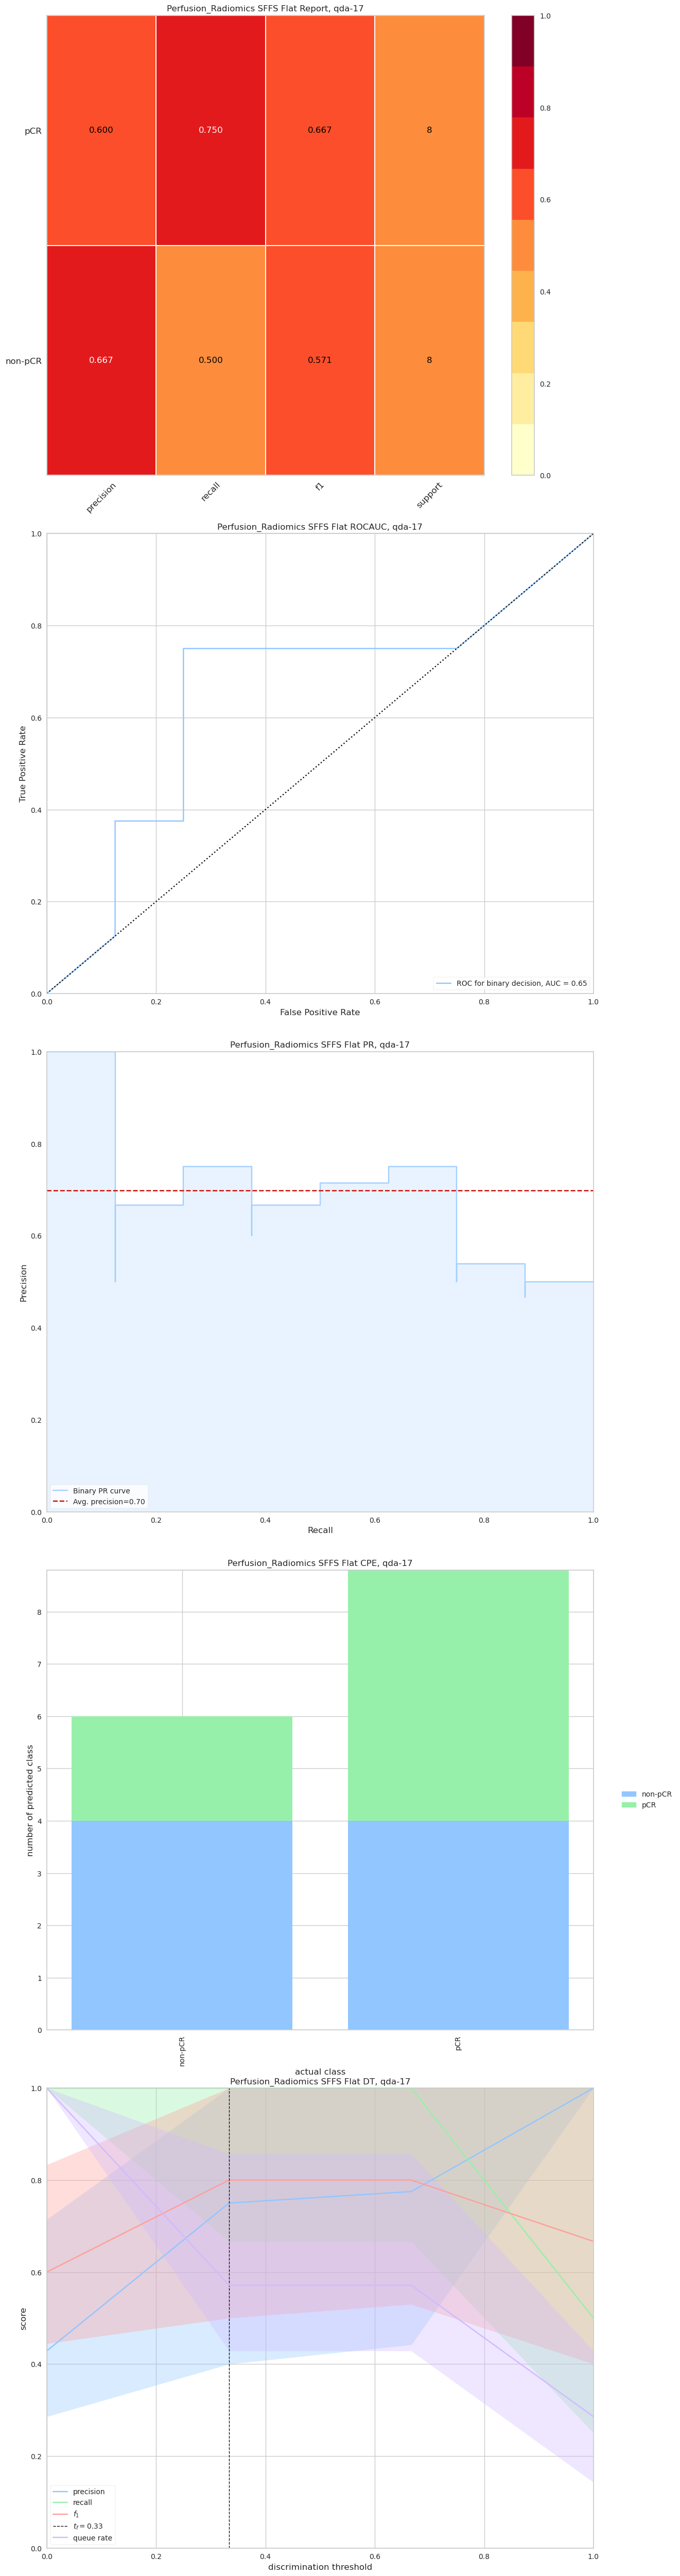

In [45]:
feature_selection_method = config_dict["feature_selection"]

output_file = str(Path(os.environ["ROOT_FOLDER"]).joinpath(
                        experiment_name,
                        f"{experiment_name} {feature_selection_method} {aggregation} {reduction}_{k}.png"))

plot_title = f"{experiment_name} SFFS {aggregation}"
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    report = evaluate_classifiers(ensemble_configuration, classifier_kwargs_list,
                                                train_feature_set, train_label_set,test_feature_set, test_label_set,
                                                "SFFS", aggregation, visualizers,output_file, plot_title)

# Ensemble Model Test Set Report

In [46]:
report

{'0': {'precision': 0.6666666666666666,
  'recall': 0.5,
  'f1-score': 0.5714285714285715,
  'support': 8},
 '1': {'precision': 0.6,
  'recall': 0.75,
  'f1-score': 0.6666666666666665,
  'support': 8},
 'accuracy': 0.625,
 'macro avg': {'precision': 0.6333333333333333,
  'recall': 0.625,
  'f1-score': 0.6190476190476191,
  'support': 16},
 'weighted avg': {'precision': 0.6333333333333333,
  'recall': 0.625,
  'f1-score': 0.6190476190476191,
  'support': 16},
 'roc_auc': 0.6484375}

In [59]:
val_scores = []

val_scores.append(
    {"Metric": metric,
     "Experiment": experiment_name,
     "Score": scores[0], "Section": f"Validation Set [5-CV {reduction.capitalize()}]"},
)

/opt/conda/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



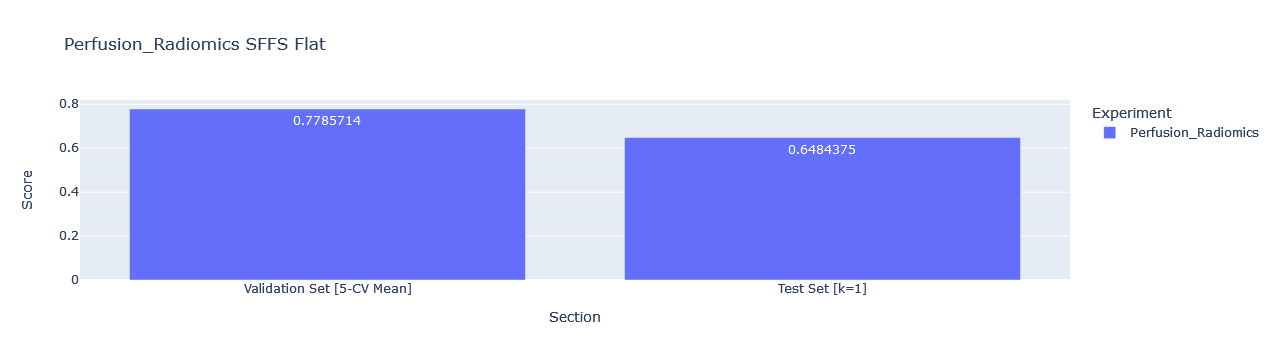

In [60]:
val_scores.append(
        {"Metric": metric,
         "Experiment": experiment_name,
         "Score": report['roc_auc'], "Section": f"Test Set [k={k}]"})

val_scores = pd.DataFrame.from_records(val_scores)
val_scores.to_excel(Path(os.environ["ROOT_FOLDER"]).joinpath(experiment_name, f"{plot_title}.xlsx"))

px.bar(val_scores, x='Section', y='Score', color="Experiment", text_auto=True, title=plot_title,
                 barmode='group')